## Business Context

With the increasing popularity and ease of access to online hotel booking platforms, customers tend to make reservations in advance to avoid any last-minute rush and higher prices. These online platforms offer flexible cancellation options, in some cases even a day before reservation. To compete with this, even offline bookings have increased the flexibility in cancellations. This has led to an increase in the growing number of cancellations, with one of the primary reasons being last-minute changes in travel plans. These sudden changes can result from unforeseen circumstances, such as personal emergencies, flight delays, or unexpected events at the travel destination.

Hotel booking cancellations become a crucial problem to solve as it leads to revenue loss and operational inefficiencies. The cancellation of bookings impacts a hotel on various fronts:

1. Loss of revenue when the hotel cannot resell the room

2. Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms

3. Lowering prices last minute, so the hotel can resell a room, resulting in reduced profit margins

## Problem Definition

The INN Hotels Group has been contending with the challenge of rising cancellations for nearly a year now. However, the last three months witnessed a **rise in inventory loss due to cancellation rise to an all-time high of 18%**. This has led to a jump in the **revenue loss to an all-time high of approx. \$0.25 million annually**. This has significantly impacted their profit margins.

- In the current context, inventory refers to a hotel room, and the inability to sell one leads to inventory loss

The group has been using heuristic mechanisms (rule and domain expert-based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far hasn't been effective (neither efficient nor scalable), as evident from the magnitude of losses they are incurring.

The group has decided that they **need a Data Science-based solution to predict the likelihood of a booking being canceled** as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them significantly **minimize revenue loss and improve operational efficiency**.

In [3]:
# import thel ibrararies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
warnings.filterwarnings('ignore')

### load the past data and new data

In [5]:
past_data = pd.read_csv('INNHotelsGroup_pastdata.csv')
new_data  = pd.read_csv('INNHotelsGroup_newdata.csv')

In [6]:
#lets check their shape
print(past_data.shape)
print(new_data.shape)

(27093, 12)
(3583, 11)


In [7]:
past_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN


In [8]:
new_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_128127,4,Online,1,103.0,1,0,2022-07-01,1,1,Not Canceled
1,INNHG_128128,147,Online,2,103.7,2,2,2022-07-01,0,2,Not Canceled


#### lets understand exactly how many bookings were cancelled and rebooked at last moment from JAN-21 to JULY-22

In [10]:
# lets see how many bookings were cancelled

In [11]:
past_data['booking_status'].value_counts(normalize =  True)

booking_status
Not Canceled    0.673089
Canceled        0.326911
Name: proportion, dtype: float64

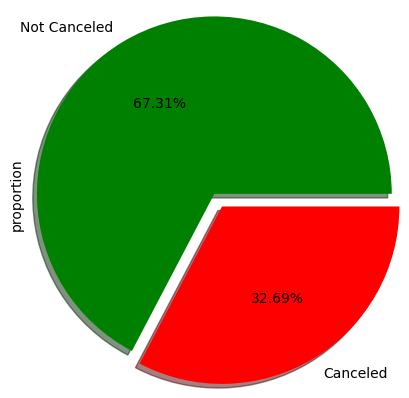

In [12]:
past_data['booking_status'].value_counts(normalize =  True).plot(kind = 'pie',autopct = '%.2f%%',radius = 1.2,colors = ['green','red'],shadow = True,explode =[0,0.1])
plt.show()

In [13]:
# lets see how many cancelled were rebooked
book_data = past_data[past_data['booking_status'] =='Canceled']

In [14]:
book_data['rebooked'].value_counts(normalize = True)

rebooked
No     0.800723
Yes    0.199277
Name: proportion, dtype: float64

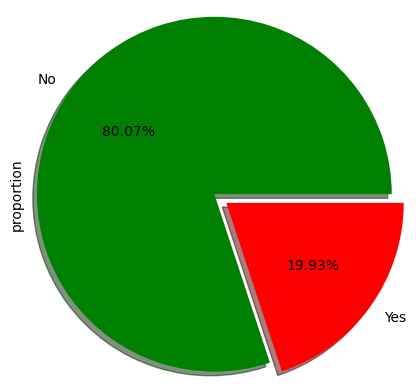

In [15]:
book_data['rebooked'].value_counts(normalize =  True).plot(kind = 'pie',autopct = '%.2f%%',radius = 1.2,colors = ['green','red'],shadow = True,explode =[0,0.1])
plt.show()

Inference:- Here we can see that out of all the booking ~33% bookings are being 
cancelled and out of these 33% only ~20% booking are rebooked. Hence the Heuristic approach
is not affective at all, the inventory lossed are still very high

### Exploring the data

In [18]:
past_data.head()

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN
2,INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled,NaN
3,INNHG_101037,23,Online,0,84.70,1,2,2021-01-01,0,0,Not Canceled,NaN
4,INNHG_101038,46,Online,1,149.40,2,2,2021-01-01,0,3,Canceled,No


In [19]:
past_data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,27093.0,81.605249,84.901428,0.0,14.0,55.0,118.0,443.0
no_of_special_requests,27093.0,0.556454,0.743715,0.0,0.0,0.0,1.0,5.0
avg_price_per_room,27093.0,101.025910,34.557289,0.0,79.0,97.0,119.0,540.0
no_of_adults,27093.0,1.825822,0.512182,0.0,2.0,2.0,2.0,4.0
no_of_weekend_nights,27093.0,0.778319,0.861787,0.0,0.0,1.0,1.0,6.0
required_car_parking_space,27093.0,0.028864,0.167426,0.0,0.0,0.0,0.0,1.0
no_of_week_nights,27093.0,2.171373,1.386023,0.0,1.0,2.0,3.0,17.0


In [20]:
# Booking ID is a redundant column lets make it an index.
past_data.set_index('booking_id',inplace = True)
new_data.set_index('booking_id',inplace = True)

In [21]:
# we also need to change the data type of columns 'Arrival Date' to datatimme
past_data['arrival_date'] = pd.to_datetime(past_data['arrival_date'],format = '%Y-%M-%d')
new_data['arrival_date'] = pd.to_datetime(new_data['arrival_date'],format = '%Y-%M-%d')          

In [22]:
past_data.dtypes

lead_time                              int64
market_segment_type                   object
no_of_special_requests                 int64
avg_price_per_room                   float64
no_of_adults                           int64
no_of_weekend_nights                   int64
arrival_date                  datetime64[ns]
required_car_parking_space             int64
no_of_week_nights                      int64
booking_status                        object
rebooked                              object
dtype: object

## Univariate Analysis

In [24]:
past_data.columns

Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'arrival_date', 'required_car_parking_space', 'no_of_week_nights',
       'booking_status', 'rebooked'],
      dtype='object')

In [25]:
num_cols = ['lead_time','avg_price_per_room']
cat_cols = ['market_segment_type', 'no_of_special_requests',
           'no_of_adults', 'required_car_parking_space', 
           'no_of_week_nights','booking_status', 'rebooked']

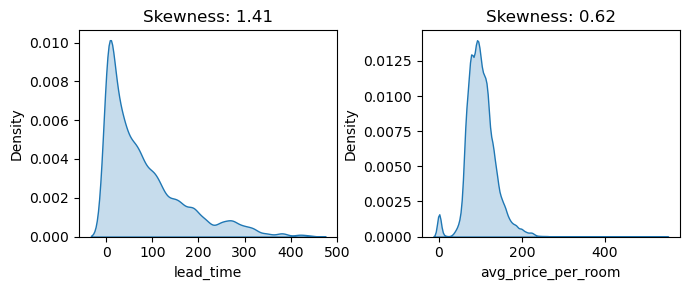

In [26]:
t = 1
plt.figure(figsize = (7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.kdeplot(data = past_data,x = i,fill = True)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+= 1
plt.tight_layout()
plt.show()
    

Inference:
* The lead time has very large values >200,which means there are bookings which have been
 made more than 200 days prior !!! 
* There are booking with average price per room is 0?

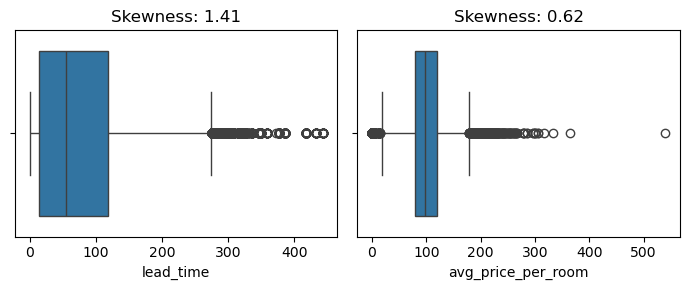

In [28]:
t = 1
plt.figure(figsize = (7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data = past_data,x = i)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+= 1
plt.tight_layout()
plt.show()
    

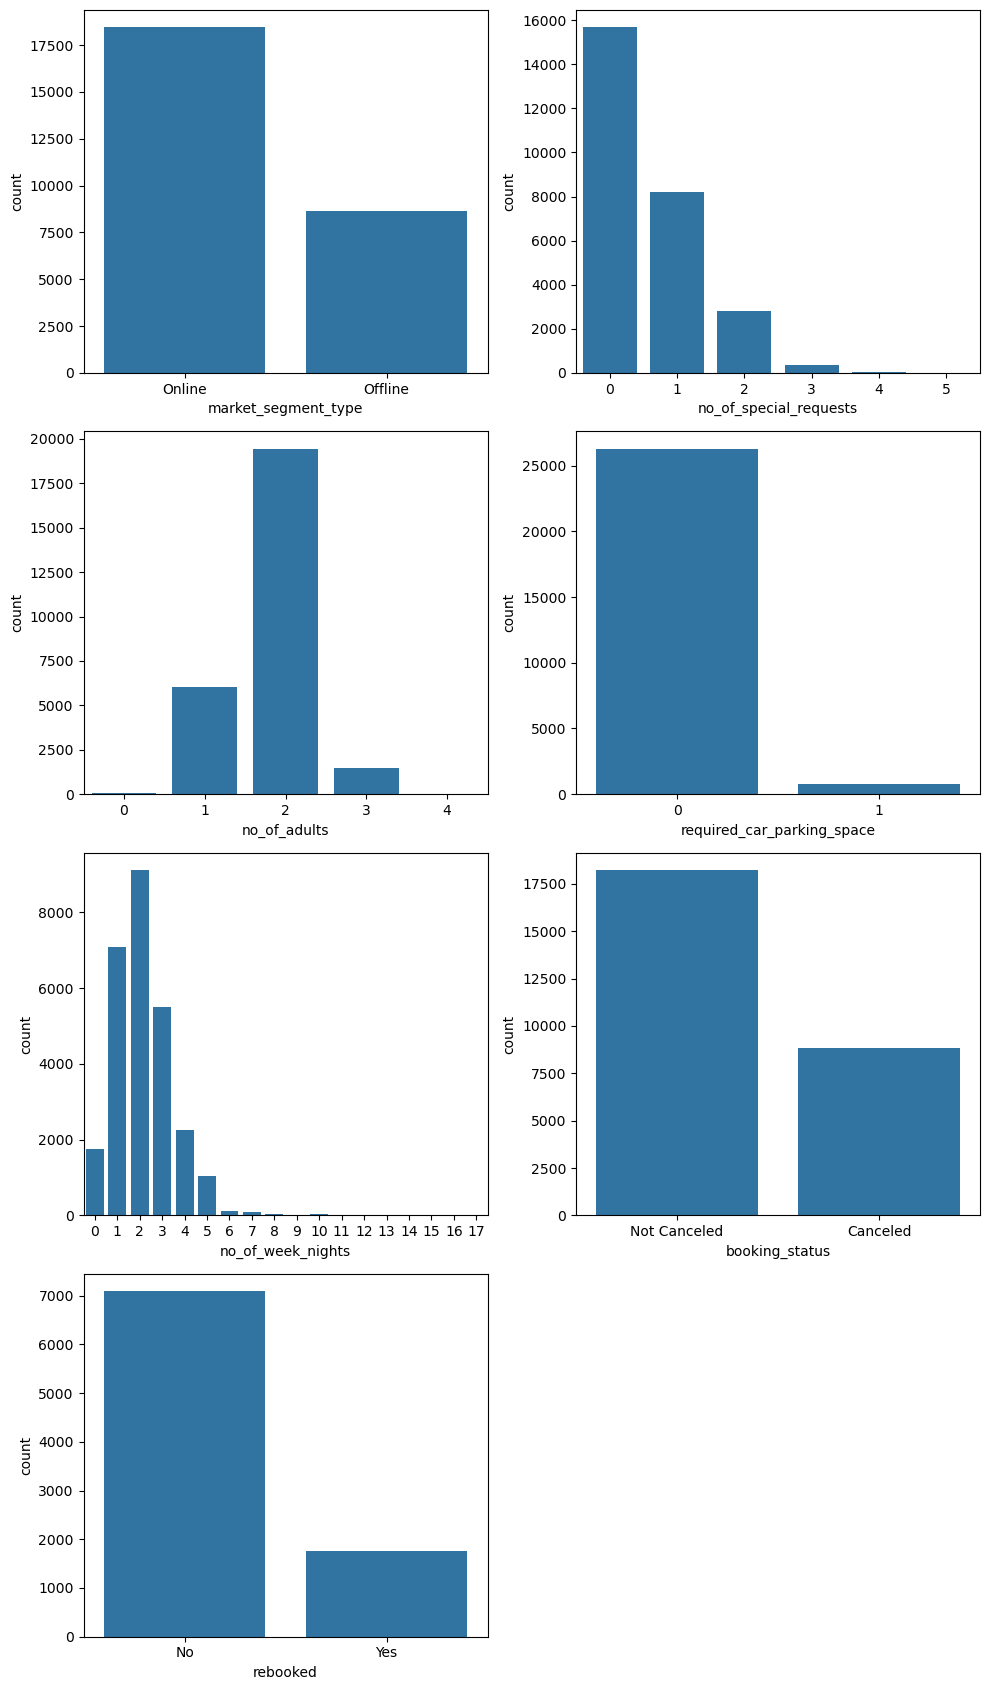

In [29]:
t = 1
plt.figure(figsize = (10,17))
for i in cat_cols:
    plt.subplot(4,2,t)
    sns.countplot(data = past_data,x = i)
    t+= 1
plt.tight_layout()
plt.show()
    

Inferences:
*
*
*

### Bivariate Analysis

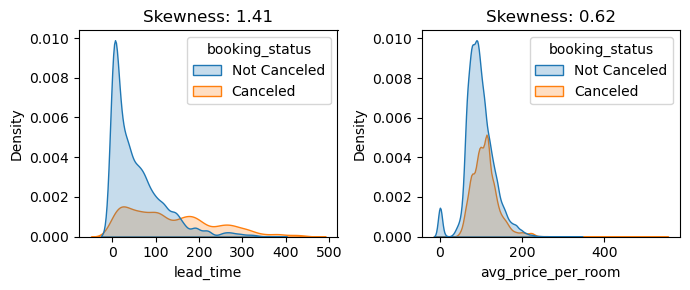

In [32]:
# Num vs Cat
t = 1
plt.figure(figsize = (7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.kdeplot(data = past_data,x = i,fill = True,hue = 'booking_status')
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+= 1
plt.tight_layout()
plt.show()
    

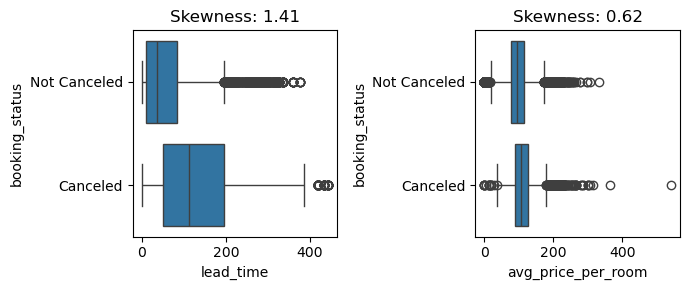

In [33]:
t = 1
plt.figure(figsize = (7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data = past_data,x = i,y = 'booking_status')
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+= 1
plt.tight_layout()
plt.show()
    

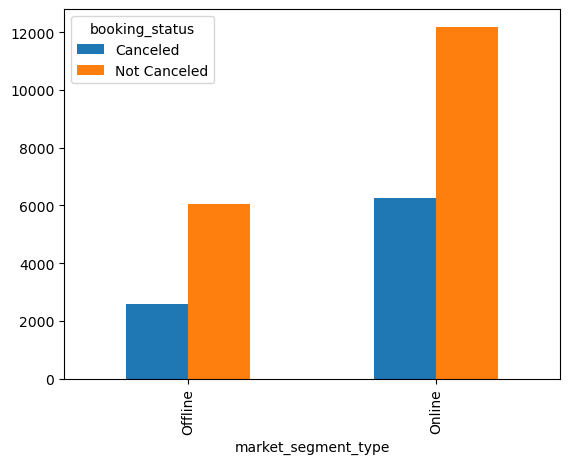

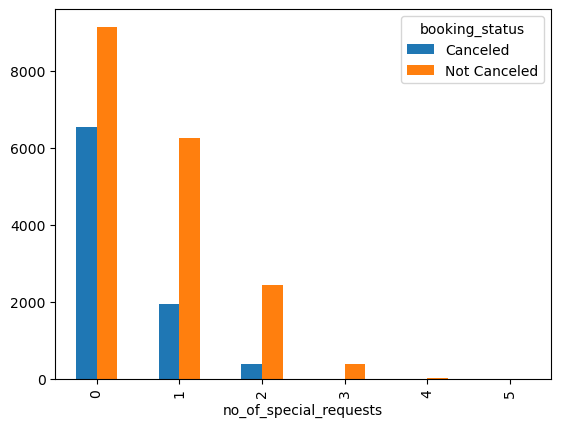

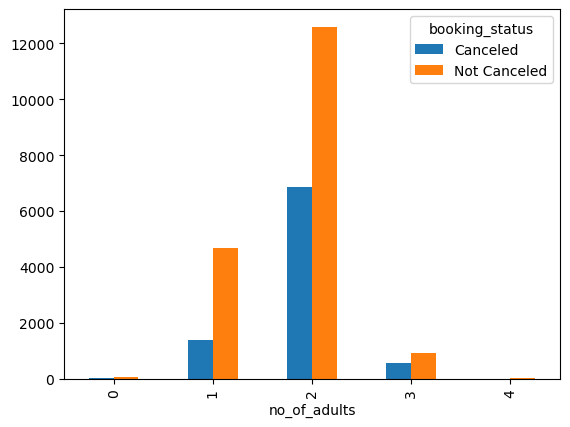

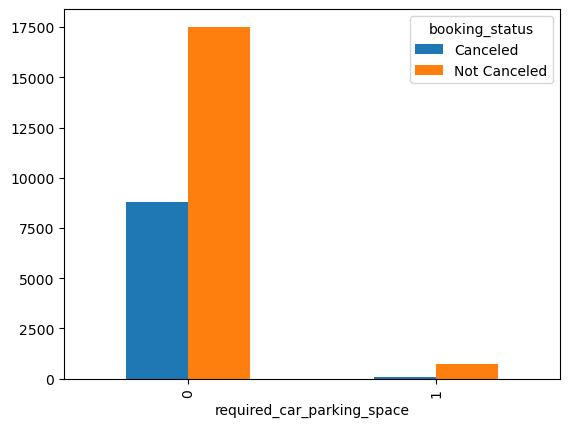

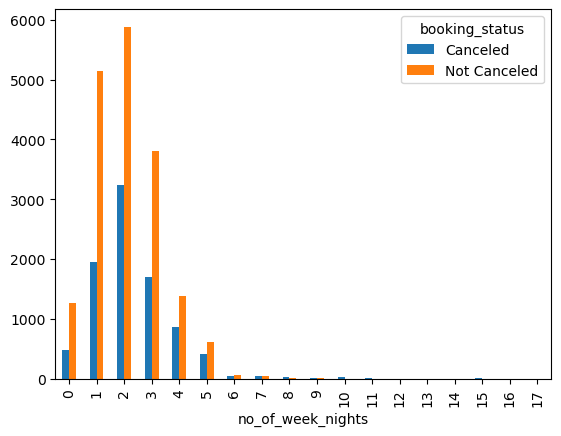

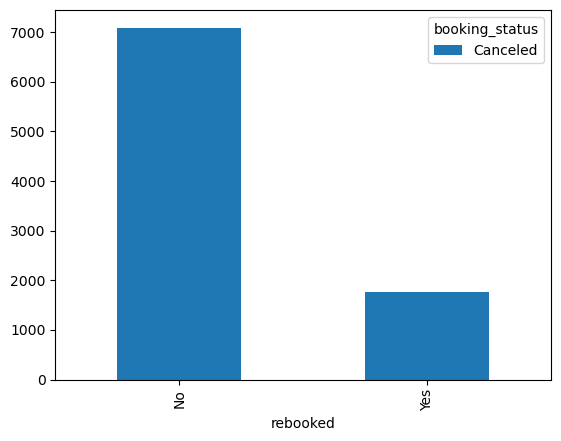

In [34]:
# Cat vs Cat (Grouped Bar plot)
for i in cat_cols:
    if i != 'booking_status':
        pd.crosstab(past_data[i],past_data['booking_status']).plot(kind = 'bar')
    plt.show()

### Multivariate Analysis

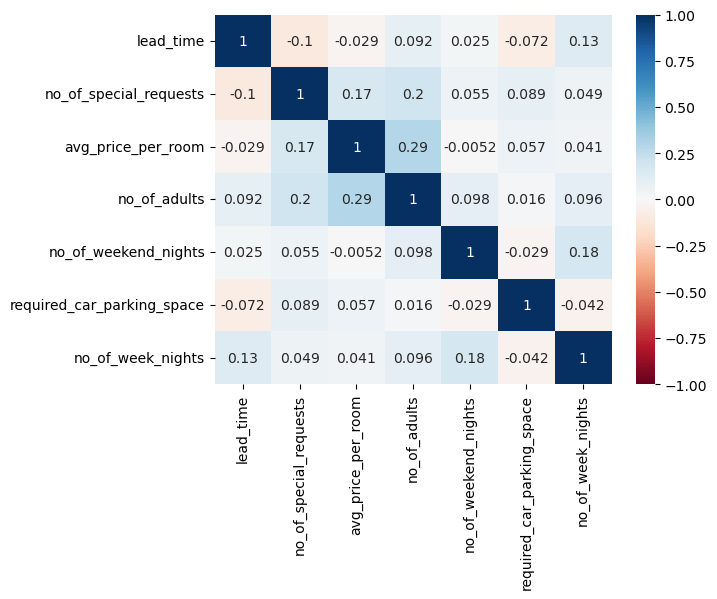

In [36]:
data = past_data.select_dtypes(include = 'number')
sns.heatmap(data.corr(),annot = True,cmap = 'RdBu',vmin = -1)
plt.show()

### Inferential Statistics

In [38]:
# Lets statistically test the inferences that we have made

In [39]:
# Lead_time vs Booking Status
samp1 = past_data[past_data['booking_status'] == 'Canceled']['lead_time']
samp2 = past_data[past_data['booking_status'] == 'Not Canceled']['lead_time']

# Lets go with 2 sample t-test
#Ho: mu1 = mu2(Lead time does not affects the booking cancellation)
#Ha: mu1!=mu2 (Lead time does affects the booking cancelations)

#Assumption 1: data must be normal(since sample size>30 lets assume its normal)
#Assumption 2: variance must be normal
#Ho: Variance are equal
#Ha: Variance are not equal
print(stats.levene(samp1,samp2)) #p value less than 0.05

#Hence variances of pop are not equal hence lets go with two sample t-est
#with unequal variances (Welch's t-test)

print(stats.ttest_ind(samp1,samp2,equal_var = False))
# Since p_value is less 0.05 we reject Ho

LeveneResult(statistic=3210.120590252021, pvalue=0.0)
TtestResult(statistic=66.84799194126163, pvalue=0.0, df=12138.394836237343)


In [40]:
samp1

booking_id
INNHG_101038     46
INNHG_101046     62
INNHG_101050     52
INNHG_101051    208
INNHG_101056      3
               ... 
INNHG_128122    113
INNHG_128123     11
INNHG_128124     35
INNHG_128125     68
INNHG_128126    158
Name: lead_time, Length: 8857, dtype: int64

In [41]:
past_data

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
booking_id,,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,2021-01-01 00:01:00,0,0,Not Canceled,NaN
INNHG_101035,34,Online,2,125.10,2,2,2021-01-01 00:01:00,0,0,Not Canceled,NaN
INNHG_101036,24,Online,1,71.69,2,2,2021-01-01 00:01:00,0,0,Not Canceled,NaN
INNHG_101037,23,Online,0,84.70,1,2,2021-01-01 00:01:00,0,0,Not Canceled,NaN
INNHG_101038,46,Online,1,149.40,2,2,2021-01-01 00:01:00,0,3,Canceled,No
...,...,...,...,...,...,...,...,...,...,...,...
INNHG_128122,113,Offline,0,85.00,2,1,2022-01-30 00:06:00,0,3,Canceled,Yes
INNHG_128123,11,Online,1,139.00,2,0,2022-01-30 00:06:00,0,3,Canceled,No
INNHG_128124,35,Online,0,117.90,2,0,2022-01-30 00:06:00,0,3,Canceled,No


In [42]:
# Avg_room_price vs booking_cancelation
samp1 = past_data[past_data['booking_status'] == 'Canceled']['avg_price_per_room']
samp2 = past_data[past_data['booking_status'] == 'Not Canceled']['avg_price_per_room']

# Lets go with 2 sample t-test
#Ho: mu1 = mu2(avg_price_per_room does not affects the booking cancellation)
#Ha: mu1!=mu2 (avg_price_per_room  does affects the booking cancelations)

#Assumption 1: data must be normal(since sample size>30 lets assume its normal)
#Assumption 2: variance must be normal
#Ho: Variance are equal
#Ha: Variance are not equal
print(stats.levene(samp1,samp2)) #p value less than 0.05

#Hence variances of pop are not equal hence lets go with two sample t-est
#with unequal variances (Welch's t-test)

print(stats.ttest_ind(samp1,samp2,equal_var = False))
# Since p_value is less 0.05 we reject Ho

LeveneResult(statistic=29.227364523829735, pvalue=6.490728476679038e-08)
TtestResult(statistic=29.9727805387597, pvalue=8.462441935004689e-193, df=18575.27155776574)


In [43]:
# all cat columns vs booking status
#chi-square test for independence
#Ho: No relation in categories
#Ha: There is relation in categories
for i in cat_cols:
    if i not in ['booking_status','rebooked']:
        ct = pd.crosstab(past_data['booking_status'],past_data[i])
        print(i,stats.chi2_contingency(ct)[1])
#since p-values for all the category columns are less than 0.05 
#all the cat columns are statistically significant

market_segment_type 7.806389643886697e-11
no_of_special_requests 0.0
no_of_adults 1.441185511500568e-73
required_car_parking_space 5.626905783478662e-49
no_of_week_nights 7.318602549508705e-65


## Data Preprocessing

In [45]:
# lets remove the 'rebooked column' from the predictive modelling as this info
# will not be available for future data

In [46]:
past_data.drop(columns = ['rebooked'],inplace = True)

In [47]:
past_data.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,2021-01-01 00:01:00,0,0,Not Canceled
INNHG_101035,34,Online,2,125.10,2,2,2021-01-01 00:01:00,0,0,Not Canceled


### Missing Values

In [49]:
past_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

In [50]:
new_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

### Outlier Treatment

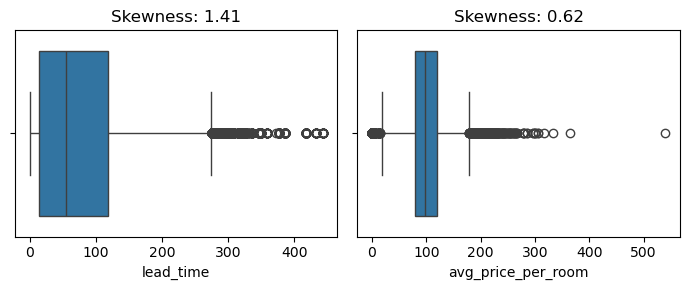

In [52]:
t = 1
plt.figure(figsize = (7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data = past_data,x = i)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+= 1
plt.tight_layout()
plt.show()
    

In [53]:
# Lets cap the extreme outliers
for i in num_cols:
    q1,q3 = np.quantile(past_data[i],[0.25,0.75])
    iqr = q3-q1
    ul,ll = q3+2.5*iqr,q1-2.5*iqr
    past_data[i] = past_data[i].apply(lambda x: ul if x>ul else ll if x<ll else x)

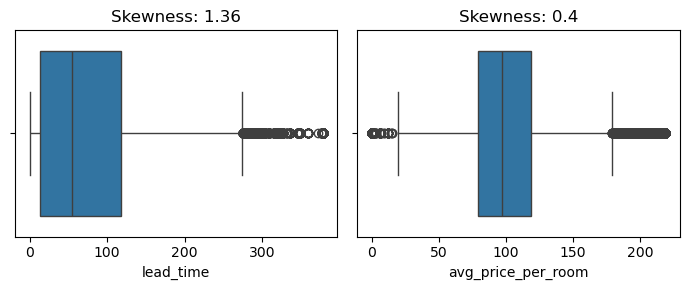

In [54]:
t = 1
plt.figure(figsize = (7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data = past_data,x = i)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+= 1
plt.tight_layout()
plt.show()
    

### Feature Encoding

In [56]:
past_data = pd.get_dummies(past_data,columns = ['market_segment_type'],drop_first = True,dtype = int)

In [57]:
new_data = pd.get_dummies(new_data,columns = ['market_segment_type'],drop_first = True,dtype = int)

In [58]:
# Let do ordinal encoding for booking status
past_data['booking_status'] = past_data['booking_status'].map({'Canceled':1,
                                                               'Not Canceled':0})

In [59]:
# Let do ordinal encoding for booking status
new_data['booking_status'] = new_data['booking_status'].map({'Canceled':1,
                                                               'Not Canceled':0})

In [60]:
new_data.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online
booking_id,,,,,,,,,,
INNHG_128127,4,1,103.0,1,0,2022-01-01 00:07:00,1,1,0,1
INNHG_128128,147,2,103.7,2,2,2022-01-01 00:07:00,0,2,0,1


### Feature Transformation

In [62]:
transformer = PowerTransformer(standardize = False)

In [63]:
past_data[num_cols] = transformer.fit_transform(past_data[num_cols])
new_data[num_cols] = transformer.transform(new_data[num_cols])

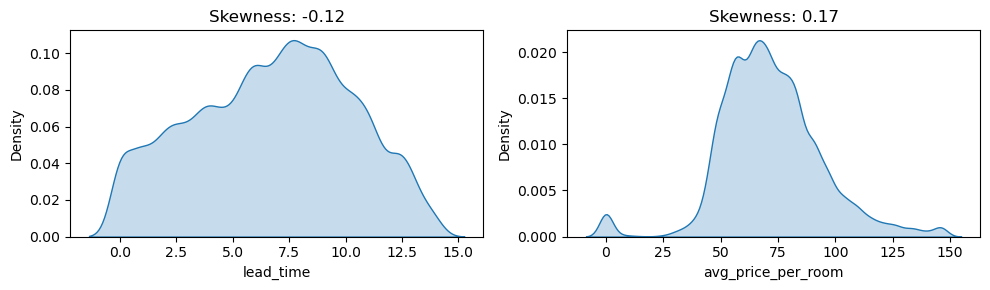

In [64]:
t = 1
plt.figure(figsize = (10,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.kdeplot(data = past_data,x = i,fill = True)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    t+= 1
plt.tight_layout()
plt.show()
    

### Feature Engineering(Generate new columns)

In [66]:
# lets extract month and weekday from date of arrival
past_data['arrival_month'] = past_data['arrival_date'].dt.month
past_data['arrival_wkday'] = past_data['arrival_date'].dt.weekday

In [67]:
past_data.drop(columns = 'arrival_date',inplace = True)

In [68]:
new_data['arrival_month'] = new_data['arrival_date'].dt.month
new_data['arrival_wkday'] = new_data['arrival_date'].dt.weekday
new_data.drop(columns = 'arrival_date',inplace = True)

In [69]:
# we can add number of weekday and weekdend in the booking and get stay duration
past_data['total_nights'] = past_data['no_of_week_nights']+past_data['no_of_weekend_nights']

In [70]:
new_data['total_nights'] = new_data['no_of_week_nights']+new_data['no_of_weekend_nights']

In [71]:
past_data

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights
booking_id,,,,,,,,,,,,
INNHG_101034,0.000000,0,61.729381,1,1,0,0,0,1,1,4,1
INNHG_101035,5.784470,2,87.801167,2,2,0,0,0,1,1,4,2
INNHG_101036,4.986923,1,52.818520,2,2,0,0,0,1,1,4,2
INNHG_101037,4.894729,0,61.510571,1,2,0,0,0,1,1,4,2
INNHG_101038,6.541683,1,103.222808,2,2,0,3,1,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
INNHG_128122,9.191895,0,61.709493,2,1,0,3,1,0,1,6,4
INNHG_128123,3.467147,1,96.653118,2,0,0,3,1,1,1,6,3
INNHG_128124,5.854397,0,83.181042,2,0,0,3,1,1,1,6,3


In [72]:
# we can also calculate the departure day from total nights and arrival weekday
# weekday

In [73]:
past_data['depart_wkday'] = past_data['arrival_wkday'] + past_data['total_nights']

In [74]:
new_data['depart_wkday'] = new_data['arrival_wkday'] + new_data['total_nights']

In [75]:
def setting_weekday(num):
    if num>6:
        return num%7
    else:
        return num

In [76]:
past_data['depart_wkday'] = past_data['depart_wkday'].apply(setting_weekday)
new_data['depart_wkday'] = new_data['depart_wkday'].apply(setting_weekday)

In [77]:
past_data.head()

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,market_segment_type_Online,arrival_month,arrival_wkday,total_nights,depart_wkday
booking_id,,,,,,,,,,,,,
INNHG_101034,0.000000,0,61.729381,1,1,0,0,0,1,1,4,1,5
INNHG_101035,5.784470,2,87.801167,2,2,0,0,0,1,1,4,2,6
INNHG_101036,4.986923,1,52.818520,2,2,0,0,0,1,1,4,2,6
INNHG_101037,4.894729,0,61.510571,1,2,0,0,0,1,1,4,2,6
INNHG_101038,6.541683,1,103.222808,2,2,0,3,1,1,1,4,5,2


In [78]:
past_data.shape

(27093, 13)

In [79]:
new_data.shape

(3583, 13)

# Predictive Modeling

In [232]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier,VotingClassifier,StackingClassifier,GradientBoostingClassifier)
from sklearn.metrics import (roc_auc_score,roc_curve,classification_report,cohen_kappa_score,accuracy_score,recall_score,precision_score,f1_score)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score

### Train test split

In [83]:
x_train = past_data.drop(columns = ['booking_status'])
y_train = past_data['booking_status']
x_test = new_data.drop(columns = ['booking_status'])
y_test = new_data['booking_status']                   

In [84]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(27093, 12) (27093,)
(3583, 12) (3583,)


### Modular Coding (Creating functions for tasks)

In [86]:
def model_train(model,xtrain,ytrain,xtest,ytest):

    m = model
    m.fit(xtrain,ytrain)
    pred_h = m.predict(xtest)
    pred_s = m.predict_proba(xtest)[:,1]
    
    return m,pred_h,pred_s

In [87]:
def model_score(predh,preds,ytest=y_test):
    print('Classification Report')
    print(classification_report(ytest,predh))
    fpr,tpr,thres = roc_curve(ytest,preds)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],color = 'red',ls = '--')
    plt.title(f'ROC AUC: {round(roc_auc_score(ytest,preds),4)}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [88]:
def model_tuning(model,grid,x = x_train,y = y_train,folds = 6,score='roc_auc'):

    gscv = GridSearchCV(estimator = model,param_grid = grid,scoring = score,cv = folds,verbose = 1,n_jobs = 5)
    gscv.fit(x,y)
    print('Best Score',gscv.best_score_)
    return gscv.best_params_

In [89]:
mod = []
accu = []
rec = []
prec = []
f1= []
ck = []
auc = []

In [90]:
def model_scorecard(model,predh,preds,ytest=y_test):
    mod.append(str(model))
    accu.append(accuracy_score(ytest,predh))
    prec.append(precision_score(ytest,predh))
    rec.append(recall_score(ytest,predh))
    f1.append(f1_score(ytest,predh))
    ck.append(cohen_kappa_score(ytest,predh))
    auc.append(roc_auc_score(ytest,preds))
    scorecard = pd.DataFrame({'Accuracy':accu,'Precision':prec,'Recall':rec,'F1':f1,'Cohen kappa':ck,'ROC AUC':auc},index = mod)
    
    return scorecard

In [91]:
model_lr,predh_lr,preds_lr = model_train(LogisticRegression(class_weight = 'balanced'),
                                         x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.60      0.72      2383
           1       0.52      0.86      0.65      1200

    accuracy                           0.69      3583
   macro avg       0.71      0.73      0.68      3583
weighted avg       0.77      0.69      0.69      3583



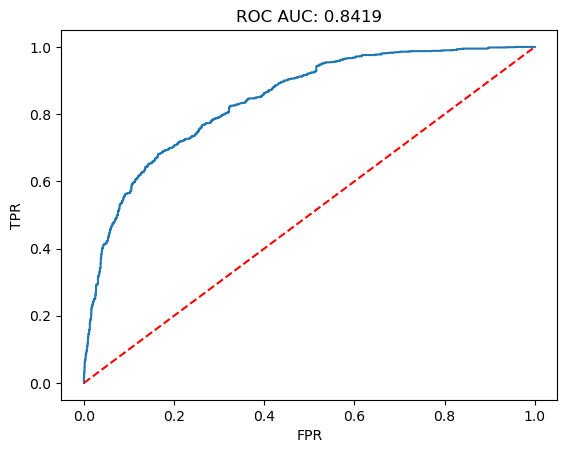

In [92]:
model_score(predh_lr,preds_lr)

In [93]:
model_scorecard(model_lr,predh_lr,preds_lr)

,Accuracy,Precision,Recall,F1,Cohen kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.687134,0.519799,0.864167,0.649139,0.396887,0.841879


### Naive Bayes

In [95]:
model_gnb,predh_gnb,preds_gnb = model_train(GaussianNB(),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.62      0.71      2383
           1       0.50      0.75      0.60      1200

    accuracy                           0.66      3583
   macro avg       0.66      0.68      0.65      3583
weighted avg       0.72      0.66      0.67      3583



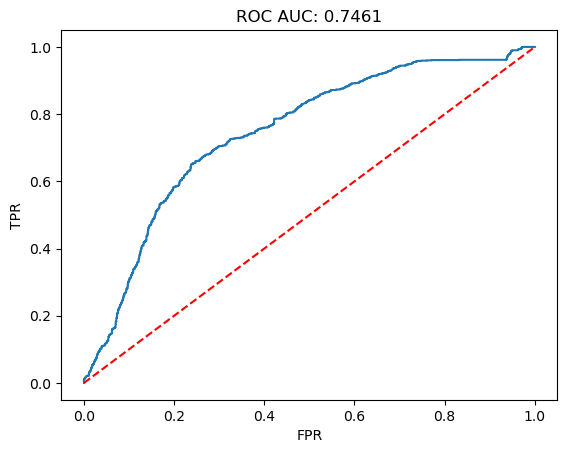

In [96]:
model_score(predh_gnb,preds_gnb)

In [97]:
model_scorecard(model_gnb,predh_gnb,preds_gnb)

,Accuracy,Precision,Recall,F1,Cohen kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.687134,0.519799,0.864167,0.649139,0.396887,0.841879
GaussianNB(),0.663131,0.498059,0.748333,0.598069,0.327688,0.746138


In [98]:
model_mnb,predh_mnb,preds_mnb= model_train(MultinomialNB(),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.86      0.80      2383
           1       0.61      0.45      0.52      1200

    accuracy                           0.72      3583
   macro avg       0.69      0.65      0.66      3583
weighted avg       0.71      0.72      0.71      3583



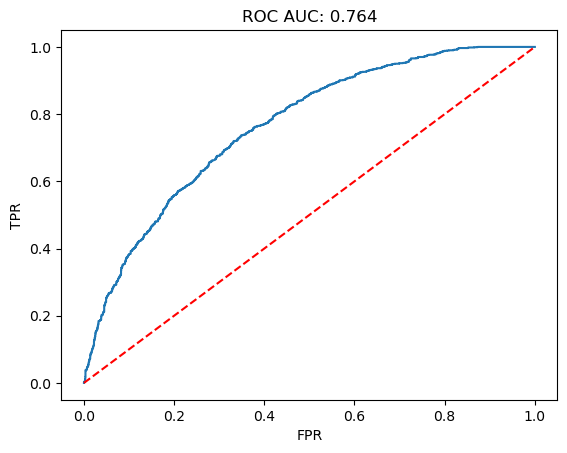

In [99]:
model_score(predh_mnb,preds_mnb)

In [100]:
model_scorecard(model_mnb,predh_mnb,preds_mnb)

,Accuracy,Precision,Recall,F1,Cohen kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.687134,0.519799,0.864167,0.649139,0.396887,0.841879
GaussianNB(),0.663131,0.498059,0.748333,0.598069,0.327688,0.746138
MultinomialNB(),0.721183,0.613559,0.452500,0.520863,0.330519,0.763984


### Decision Tree

In [102]:
tuned_params = model_tuning(DecisionTreeClassifier(class_weight = 'balanced'),
             {'max_leaf_nodes':[23,24,25,26,27,28]})

Fitting 6 folds for each of 6 candidates, totalling 36 fits
Best Score 0.8454486749564382


In [103]:
model_dt,predh_dt,preds_dt = model_train(DecisionTreeClassifier(class_weight = 'balanced',**tuned_params),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      2383
           1       0.66      0.80      0.72      1200

    accuracy                           0.79      3583
   macro avg       0.77      0.80      0.78      3583
weighted avg       0.81      0.79      0.80      3583



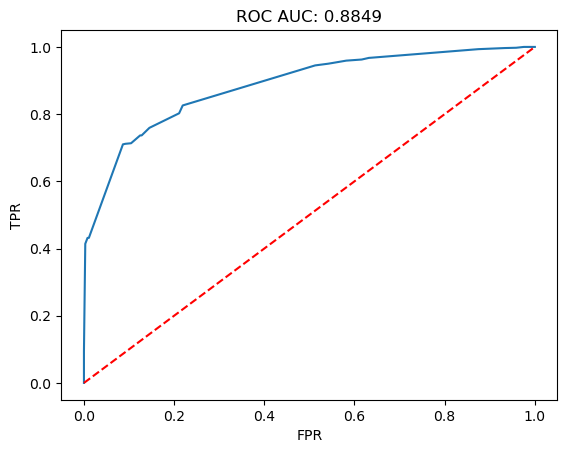

In [104]:
model_score(predh_dt,preds_dt)

In [105]:
model_scorecard(model_dt,predh_dt,preds_dt)

,Accuracy,Precision,Recall,F1,Cohen kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.687134,0.519799,0.864167,0.649139,0.396887,0.841879
GaussianNB(),0.663131,0.498059,0.748333,0.598069,0.327688,0.746138
MultinomialNB(),0.721183,0.613559,0.452500,0.520863,0.330519,0.763984
"DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=26)",0.793469,0.656889,0.802500,0.722431,0.560578,0.884881


### Random Forest 

In [107]:
tuned_params = model_tuning(RandomForestClassifier(max_features = None,class_weight = 'balanced'),
                            grid = {'n_estimators':[45,48,50,52,53],'max_depth':[4,7,9]})

Fitting 6 folds for each of 15 candidates, totalling 90 fits
Best Score 0.8789978037290833


In [196]:
model_rf,predh_rf,preds_rf = model_train(RandomForestClassifier(max_features = None,class_weight = 'balanced',**tuned_params),
                                         x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2383
           1       0.75      0.81      0.78      1200

    accuracy                           0.84      3583
   macro avg       0.82      0.83      0.83      3583
weighted avg       0.85      0.84      0.85      3583



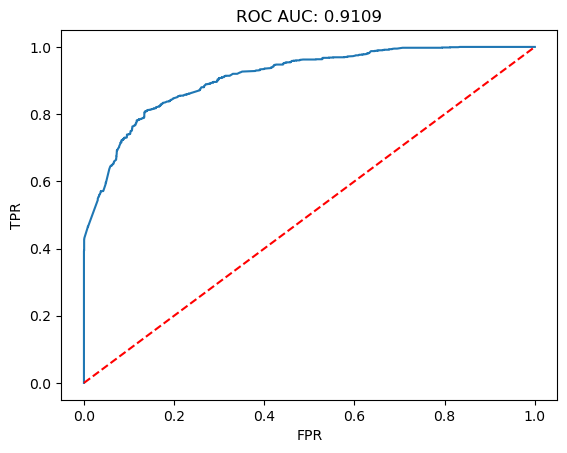

In [198]:
model_score(predh_rf,preds_rf)

In [200]:
model_scorecard(model_rf,predh_rf,preds_rf)

,Accuracy,Precision,Recall,F1,Cohen kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.687134,0.519799,0.864167,0.649139,0.396887,0.841879
GaussianNB(),0.663131,0.498059,0.748333,0.598069,0.327688,0.746138
MultinomialNB(),0.721183,0.613559,0.452500,0.520863,0.330519,0.763984
"DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=26)",0.793469,0.656889,0.802500,0.722431,0.560578,0.884881
"RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=None,\n n_estimators=53)",0.843706,0.746154,0.808333,0.776000,0.656278,0.910903


### Adaboost

In [204]:
tuned_params = model_tuning(AdaBoostClassifier(random_state = 2),grid={'n_estimators':[50,70,100,120,150],
                                                       'learning_rate':[0.01,0.1,1]})

Fitting 6 folds for each of 15 candidates, totalling 90 fits
Best Score 0.8590677673601727


In [206]:
tuned_params

{'learning_rate': 1, 'n_estimators': 50}

In [210]:
model_ada,predh_ada,preds_ada = model_train(AdaBoostClassifier(random_state = 2,**tuned_params),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      2383
           1       0.66      0.76      0.71      1200

    accuracy                           0.79      3583
   macro avg       0.77      0.78      0.77      3583
weighted avg       0.80      0.79      0.79      3583



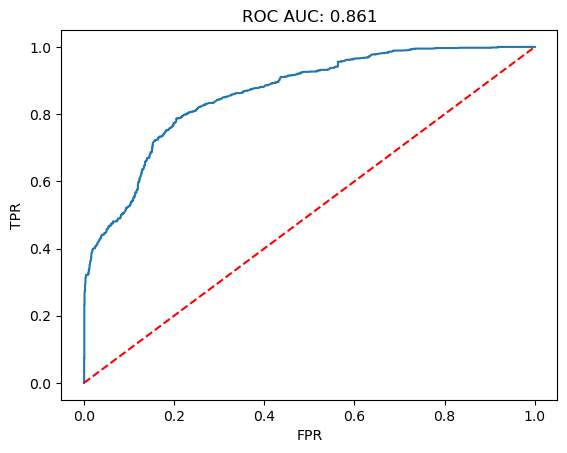

In [212]:
model_score(predh_ada,preds_ada)

In [214]:
model_scorecard(model_ada,predh_ada,preds_ada)

,Accuracy,Precision,Recall,F1,Cohen kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.687134,0.519799,0.864167,0.649139,0.396887,0.841879
GaussianNB(),0.663131,0.498059,0.748333,0.598069,0.327688,0.746138
MultinomialNB(),0.721183,0.613559,0.452500,0.520863,0.330519,0.763984
"DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=26)",0.793469,0.656889,0.802500,0.722431,0.560578,0.884881
"RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=None,\n n_estimators=53)",0.843706,0.746154,0.808333,0.776000,0.656278,0.910903
"AdaBoostClassifier(learning_rate=1, random_state=2)",0.790957,0.664000,0.760833,0.709126,0.547154,0.861009


### Gradient Boosting

In [219]:
tuned_params = model_tuning(GradientBoostingClassifier(random_state = 2),
            grid = {'n_estimators':[50,70,90,110,120],'learning_rate':[0.01,0.1,1],'max_depth':[5,7,9]})

Fitting 6 folds for each of 45 candidates, totalling 270 fits
Best Score 0.8842740200128585


In [221]:
model_gbm,predh_gbm,preds_gbm = model_train(GradientBoostingClassifier(random_state = 2,**tuned_params),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2383
           1       0.78      0.78      0.78      1200

    accuracy                           0.85      3583
   macro avg       0.83      0.83      0.83      3583
weighted avg       0.85      0.85      0.85      3583



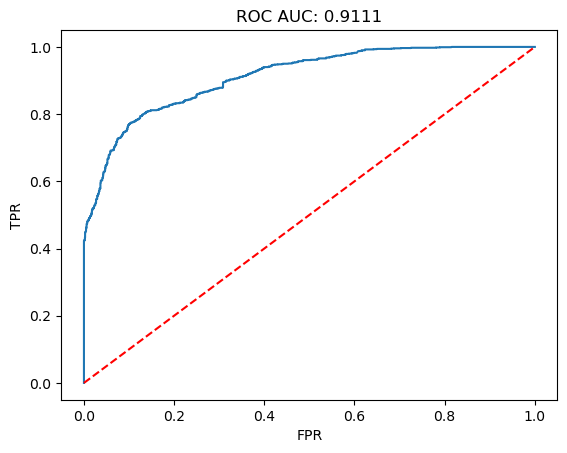

In [222]:
model_score(predh_gbm,preds_gbm)

In [225]:
model_scorecard(model_gbm,predh_gbm,preds_gbm)

,Accuracy,Precision,Recall,F1,Cohen kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.687134,0.519799,0.864167,0.649139,0.396887,0.841879
GaussianNB(),0.663131,0.498059,0.748333,0.598069,0.327688,0.746138
MultinomialNB(),0.721183,0.613559,0.452500,0.520863,0.330519,0.763984
"DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=26)",0.793469,0.656889,0.802500,0.722431,0.560578,0.884881
"RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=None,\n n_estimators=53)",0.843706,0.746154,0.808333,0.776000,0.656278,0.910903
"AdaBoostClassifier(learning_rate=1, random_state=2)",0.790957,0.664000,0.760833,0.709126,0.547154,0.861009
"GradientBoostingClassifier(max_depth=5, n_estimators=90, random_state=2)",0.850684,0.775934,0.779167,0.777547,0.665176,0.911089


### XGBoost

In [234]:
tuned_params = model_tuning(XGBClassifier(),grid = {'n_estimators':[70,100,120,150],'learning_rate':[0.1,0.01],
                                                    'gamma':[5,7,9]})

Fitting 6 folds for each of 24 candidates, totalling 144 fits
Best Score 0.8863798752854756


In [236]:
model_xgb,predh_xgb,preds_xgb = model_train(XGBClassifier(**tuned_params),x_train,y_train,x_test,y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2383
           1       0.79      0.78      0.78      1200

    accuracy                           0.86      3583
   macro avg       0.84      0.84      0.84      3583
weighted avg       0.86      0.86      0.86      3583



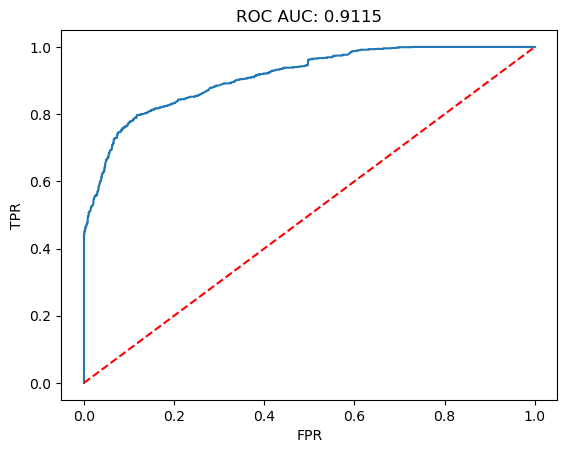

In [238]:
model_score(predh_xgb,preds_xgb)

In [240]:
model_scorecard(model_xgb,predh_xgb,preds_xgb)

,Accuracy,Precision,Recall,F1,Cohen kappa,ROC AUC
LogisticRegression(class_weight='balanced'),0.687134,0.519799,0.864167,0.649139,0.396887,0.841879
GaussianNB(),0.663131,0.498059,0.748333,0.598069,0.327688,0.746138
MultinomialNB(),0.721183,0.613559,0.452500,0.520863,0.330519,0.763984
"DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=26)",0.793469,0.656889,0.802500,0.722431,0.560578,0.884881
"RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=None,\n n_estimators=53)",0.843706,0.746154,0.808333,0.776000,0.656278,0.910903
"AdaBoostClassifier(learning_rate=1, random_state=2)",0.790957,0.664000,0.760833,0.709126,0.547154,0.861009
"GradientBoostingClassifier(max_depth=5, n_estimators=90, random_state=2)",0.850684,0.775934,0.779167,0.777547,0.665176,0.911089
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=7, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=0.1, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=70,\n n_jobs=None, num_parallel_tree=None, ...)",0.857382,0.793191,0.776667,0.784842,0.678201,0.911499


### Voting

In [284]:
base_estimators = [('RF',model_rf),
                   ('GBM',model_gbm),
                   ('XGB',model_xgb)]     

In [286]:
model_vot = VotingClassifier(estimators = base_estimators,voting = 'soft')

In [288]:
model_vot.fit(x_train,y_train)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=7,
                                                     max_features=None,
                                                     n_estimators=53)),
                             ('GBM',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=90,
                                                         random_state=2)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=No...
                                            feature_weights=None, gamma=7,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=70, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [290]:
predh_vot = model_vot.predict(x_test)

In [292]:
preds_vot = model_vot.predict_proba(x_test)[:,1]

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2383
           1       0.77      0.79      0.78      1200

    accuracy                           0.85      3583
   macro avg       0.83      0.84      0.83      3583
weighted avg       0.85      0.85      0.85      3583



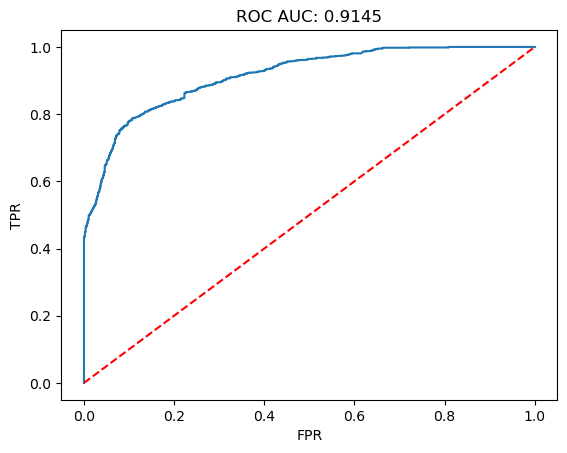

In [294]:
model_score(predh_vot,preds_vot)

In [302]:
scorecard  = model_scorecard(model_vot,predh_vot,preds_vot)

In [304]:
scorecard.sort_values(by = 'ROC AUC',ascending = False)

,Accuracy,Precision,Recall,F1,Cohen kappa,ROC AUC
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(class_weight='balanced',\n max_depth=7,\n max_features=None,\n n_estimators=53)),\n ('GBM',\n GradientBoostingClassifier(max_depth=5,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=No...\n feature_weights=None, gamma=7,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=0.1, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None,\n max_leaves=None,\n min_child_weight=None, missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=70, n_jobs=None,\n num_parallel_tree=None, ...))],\n voting='soft')",0.849567,0.765889,0.793333,0.779370,0.665301,0.914534
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(class_weight='balanced',\n max_depth=7,\n max_features=None,\n n_estimators=53)),\n ('GBM',\n GradientBoostingClassifier(max_depth=5,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=No...\n feature_weights=None, gamma=7,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=0.1, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None,\n max_leaves=None,\n min_child_weight=None, missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=70, n_jobs=None,\n num_parallel_tree=None, ...))],\n voting='soft')",0.849567,0.765889,0.793333,0.779370,0.665301,0.914534
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(class_weight='balanced',\n max_depth=7,\n max_features=None,\n n_estimators=53)),\n ('GBM',\n GradientBoostingClassifier(max_depth=5,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=No...\n feature_weights=None, gamma=7,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=0.1, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None,\n max_leaves=None,\n min_child_weight=None, missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=70, n_jobs=None,\n num_parallel_tree=None, ...))],\n voting='soft')",0.849567,0.765889,0.793333,0.779370,0.665301,0.914534
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(class_weight='balanced',\n max_depth=7,\n max_features=None,\n n_estimators=53)),\n ('GBM',\n GradientBoostingClassifier(max_depth=5,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=No...\n feature_weights=None, gamma=7,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=0.1, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None,\n max_leaves=None,\n min_child_weight=None, missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=70, n_jobs=None,\n num_parallel_tree=None, ...))],\n voting='soft')",0.848730,0.764045,0.793333,0.778414,0.663645,0.914371
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(class_weight='balanced',\n max_depth=7,\n max_features=None,\n n_estimators=53)),\n ('GBM',\n GradientBoostingClassifier(max_depth=5,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=No...\n feature_weights=None, gam

### Stacking

In [309]:
model_stack = StackingClassifier(cv = 6,estimators = base_estimators)

In [311]:
model_stack.fit(x_train,y_train)

StackingClassifier(cv=6,
                   estimators=[('RF',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=7,
                                                       max_features=None,
                                                       n_estimators=53)),
                               ('GBM',
                                GradientBoostingClassifier(max_depth=5,
                                                           n_estimators=90,
                                                           random_state=2)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              de...
                                              feature_weights=None, gamma=7,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=70, n_jobs=None,
                                              num_parallel_tree=None, ...))])

In [315]:
predh_stack  = model_stack.predict(x_test)
preds_stack = model_stack.predict_proba(x_test)[:,1]

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2383
           1       0.79      0.78      0.79      1200

    accuracy                           0.86      3583
   macro avg       0.84      0.84      0.84      3583
weighted avg       0.86      0.86      0.86      3583



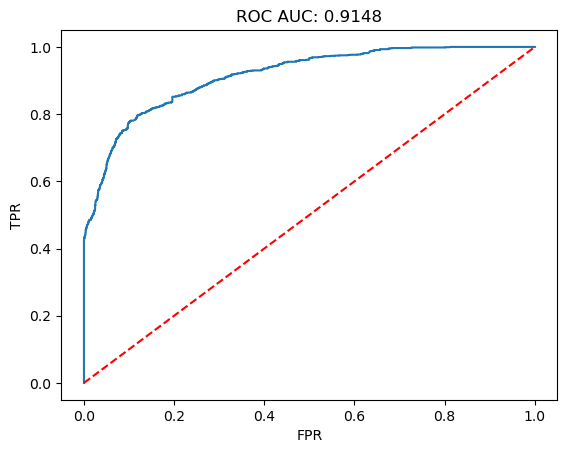

In [319]:
model_score(predh_stack,preds_stack)

In [321]:
scorecard  = model_scorecard(model_stack,predh_stack,preds_stack)

In [323]:
scorecard.sort_values(by = 'ROC AUC',ascending = False)

,Accuracy,Precision,Recall,F1,Cohen kappa,ROC AUC
"StackingClassifier(cv=6,\n estimators=[('RF',\n RandomForestClassifier(class_weight='balanced',\n max_depth=7,\n max_features=None,\n n_estimators=53)),\n ('GBM',\n GradientBoostingClassifier(max_depth=5,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None,\n de...\n feature_weights=None, gamma=7,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=0.1, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None,\n max_depth=None, max_leaves=None,\n min_child_weight=None,\n missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=70, n_jobs=None,\n num_parallel_tree=None, ...))])",0.857103,0.790051,0.780833,0.785415,0.678307,0.914753
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(class_weight='balanced',\n max_depth=7,\n max_features=None,\n n_estimators=53)),\n ('GBM',\n GradientBoostingClassifier(max_depth=5,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=No...\n feature_weights=None, gamma=7,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=0.1, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None,\n max_leaves=None,\n min_child_weight=None, missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=70, n_jobs=None,\n num_parallel_tree=None, ...))],\n voting='soft')",0.849567,0.765889,0.793333,0.779370,0.665301,0.914534
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(class_weight='balanced',\n max_depth=7,\n max_features=None,\n n_estimators=53)),\n ('GBM',\n GradientBoostingClassifier(max_depth=5,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=No...\n feature_weights=None, gamma=7,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=0.1, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None,\n max_leaves=None,\n min_child_weight=None, missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=70, n_jobs=None,\n num_parallel_tree=None, ...))],\n voting='soft')",0.849567,0.765889,0.793333,0.779370,0.665301,0.914534
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(class_weight='balanced',\n max_depth=7,\n max_features=None,\n n_estimators=53)),\n ('GBM',\n GradientBoostingClassifier(max_depth=5,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=No...\n feature_weights=None, gamma=7,\n grow_policy=None,\n importance_type=None,\n interaction_constraints=None,\n learning_rate=0.1, max_bin=None,\n max_cat_threshold=None,\n max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None,\n max_leaves=None,\n min_child_weight=None, missing=nan,\n monotone_constraints=None,\n multi_strategy=None,\n n_estimators=70, n_jobs=None,\n num_parallel_tree=None, ...))],\n voting='soft')",0.849567,0.765889,0.793333,0.779370,0.665301,0.914534
"VotingClassifier(estimators=[('RF',\n RandomForestClassifier(class_weight='balanced',\n max_depth=7,\n max_features=None,\n n_estimators=53)),\n ('GBM',\n GradientBoostingClassifier(max_depth=5,\n n_estimators=90,\n random_state=2)),\n ('XGB',\n XGBClassifier(base_score=None, booster=None,\n callbacks=None,\n colsample_bylevel=None,\n colsample_bynode=None,\n colsample_bytree=None, device=No...\n feature_weights=None, gamma=7,\n gr

### Final Model

In [326]:
# we choose stacking as our final model as it has best ROC AUC
# Now we will check for overfitting
# we will also if we can improve scores if 1 by changing cutoff classifier

In [340]:
scores = cross_val_score(estimator = model_stack,cv = KFold(n_splits = 7,shuffle = True,
                                                          random_state = 2),
                         scoring = 'roc_auc',X= x_train,y = y_train,n_jobs = 5,verbose = 1)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   7 out of   7 | elapsed:  1.3min finished


In [344]:
scores

array([0.9217931 , 0.92067785, 0.91997094, 0.92125343, 0.92774886,
       0.93235583, 0.92483786])

In [346]:
# lets improve score in class 1
fpr,tpr,thres = roc_curve(y_test,preds_stack)

In [348]:
pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':thres,'YI':tpr*(1-fpr)})\
.sort_values(by = 'YI',ascending = False)

,FPR,TPR,Threshold,YI
480,0.118758,0.796667,0.446063,0.702056
478,0.117499,0.794167,0.463148,0.700853
485,0.122115,0.798333,0.430834,0.700845
483,0.121276,0.797500,0.438820,0.700783
481,0.120436,0.796667,0.439983,0.700719
...,...,...,...,...
3,0.000000,0.005000,0.901453,0.005000
2,0.000000,0.003333,0.901722,0.003333
1,0.000000,0.000833,0.901907,0.000833
0,0.000000,0.000000,inf,0.000000


In [350]:
predh_stack_new  = (preds_stack>0.423761).astype(int)

In [352]:
print(classification_report(y_test,predh_stack_new))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2383
           1       0.77      0.80      0.78      1200

    accuracy                           0.85      3583
   macro avg       0.83      0.84      0.83      3583
weighted avg       0.85      0.85      0.85      3583



### Deployment

In [355]:
x_test.head(2)

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,market_segment_type_Online,arrival_month,arrival_wkday,total_nights,depart_wkday
booking_id,,,,,,,,,,,,
INNHG_128127,1.989422,1,73.535594,1,0,1,1,1,1,5,1,6
INNHG_128128,10.093647,2,73.991462,2,2,0,2,1,1,5,4,2


In [ ]:
# suppose there is new customer is booking a room, i want model to predict its cancellation chances

In [357]:
lt = 10
spcl = 0
price = 120
nad = 2
wend = 2
park = 0
week = 1
mark = 1
arv = 5
arvw = 4
tot = 3
depw = 0

In [369]:
lt_t,price_t = transformer.transform([[lt,price]])[0]

In [371]:
price_t

84.53117877205352

In [384]:
model_stack.predict_proba([[lt_t,spcl,price_t,nad,wend,park,week,mark,arv,arvw,tot,depw]])

array([[0.36831211, 0.63168789]])

In [392]:
# lets create some file that we need for deployment
import pickle

In [394]:
with open('final_model.pkl','wb') as file:
    pickle.dump(model_stack,file)

In [396]:
with open('tramsformer.pkl','wb') as file:
    pickle.dump(transformer,file)

In [398]:
model_stack.predict(x_test)

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [404]:
model_stack.predict_proba(x_test.iloc[0:1,:])[:,1][0]

0.062169874611513305